To start, we import all of the packages that we will need in this notebook. 

In [1]:
import glob
import pandas as pd
import numpy as np
from scipy.integrate import quad
from scipy.optimize import curve_fit

# Stage 1: Preprocess The data

### Adding the features we will need to optimize to a DataFrame and then exporting to a csv

Here we read in the well production.csv file 

In [2]:
well_productions = pd.read_csv("well productions/well production.csv")

Here we read in the csv file for each well 

In [3]:
import csv
datas = []
for file in glob.glob("well productions/*"):
    if "well production.csv" not in file:
        frame = pd.read_csv(file)
        # Strip off the extra things on the end
        frame["Name"] = file[17:-4]
        datas.append(frame)

The following function calculates the well length for each well and adds the well length of each well to the DataFrame


In [4]:
def well_length(dataframe: pd.DataFrame):
    dataframe["well length"] = dataframe["easting"].iloc[-1] - dataframe["easting"][0]

The following function calculates the number of frac stages for each well and adds the calculated value to the DataFrame

In [5]:
def frac_stages(dataframe : pd.DataFrame):
    dataframe["frac stages"] = dataframe[dataframe["proppant weight (lbs)"].isna() == False].shape[0]

The following function sets proppant per stage as "ppf." It will default to the maximum weight. 

In [6]:
def proppant_per_stage(dataframe: pd.DataFrame, find_min=False):
    if find_min:
        val = min(dataframe["proppant weight (lbs)"])
    else:
        val = max(dataframe["proppant weight (lbs)"])
    dataframe["ppf"] = val

The following function sets pump rate as "pr." It will default to the maximum rate. 

In [7]:
def pump_rate(dataframe: pd.DataFrame, find_min=False):
    if find_min:
        val = min(dataframe["pump rate (cubic feet/min)"])
    else:
        val = max(dataframe["pump rate (cubic feet/min)"])
    dataframe["pr"] = val

The below function finds how many years the well will economically produce oil, under the assumption that up to 93 barrels of oil is economical. To arrive at this value we **NEED TO RATIONALIZE THIS VALUE** 

In [8]:
def life_of_res(qi, D):
    lifetime = 1/D*np.log(qi/93)
    if lifetime < 0:
        return 0
    else: 
        return lifetime

exponential loss curve

$ q(t) = q_ie^{-Dt} $

Where $D$ is the decline rate and $q_i$ is the initial rate of production
Exponential decline curve equation

    Arguments:
        t:  Number of months the well has been producing oil 
        qi: Float. Initial production rate when well first came online.
        di: Float. Nominal decline rate (constant)
        
    Output: 
        Returns q, or the expected production rate at time t. Float.

In [9]:
def exponential_loss(t, qi, D): 
    return qi*np.exp(-D*t)

 $ q(t) = \frac{q_i}{(1+bDt)^{1.0/b}} $
 
 Hyperbolic decline curve equation
 
    Arguments:
        t:  Number of months the well has been producing oil
        qi: Float. Initial production rate when well first came online.
        b:  Float. Hyperbolic decline constant
        di: Float. Nominal decline rate at time t=0
    Output: 
        Returns q, or the expected production rate at time t. Float.

In [10]:
def hyperbolic_loss(t, qi, b, di):
    return qi/((1.0+b*di*t)**(1.0/b))

This function allows you to look at the first X months of production, and selects the highest production month as max initial production. It returns the max initial production in the first X months along with a series that contains the values of oil production for the first 12 months. 
    
    Arguments:
        number_first_months: int. Number of months from the point the well comes online
        to compare to get the max initial production rate qi (this looks at multiple months
        in case there is a production ramp-up)
        
        well_name: String. name of the well where we're attempting to get
        the max volume from.

In [11]:
def get_max_initial_production(number_first_months, well_name):
    
    row = well_productions.loc[well_productions["well name"] == well_name]
    val=0      
    row = row.filter(regex='oil')
    row=row.T.squeeze()
    
    for i in range(number_first_months):
        val = max(row[i], val)

    return val, row

The below two functions find the defined integral of the fitted exponential and hyperbolic equations between 0 and the calculated life of the reservoir. Our team found that was easier to use an integral then implement the equation fround in the "Hinge Basin" notebook. 

$ N_p = \int_0^{L_t} q(t)dt $ Where $N_p$ is total production and $L_t$ is the lifetime of the well

In [12]:
def get_cumulative_exponential(qi, D):
    return quad(exponential_loss, 0, life_of_res(qi, D), args=(qi,D))

def get_cumulative_hyperbolic(qi, b, di):
    return quad(hyperbolic_loss, 0, life_of_res(qi, di), args=(qi, b, di))

The following function will add the expected lifetime of the well when using the exponential_loss function and the hyperbolic function then add the respective values to the dataframe. Following that, it will find the cumulative production with the least amount of error out of the two functions, and add that value to the DataFrame. 

In [13]:
time_series=pd.Series(list(range(12)))
def cum_production(dataframe: pd.DataFrame, find_min=False):
    #find the name of the current well being examined
    name = dataframe["Name"][0]
    #Set qi equal to the maximum production in the first 5 months of this well's lifespan, and row equal to the series of the 
    #first 12 months' production values
    qi, row = get_max_initial_production(5, name)
    
    #Use the scipy curve_fit function to get the best possible exponential and hyperbolic curves
    popt_exp, pcov_exp = curve_fit(exponential_loss, time_series, row, bounds=(0, [qi,20]))
    popt_hyp, pcov_hyp=curve_fit(hyperbolic_loss, time_series, row,bounds=(0, [qi,2,20]))
    
    #Get the defined integral's value and error for both the exponential and hyperbolic curves
    cp_exp = get_cumulative_exponential(*popt_exp)
    cp_hyp = get_cumulative_hyperbolic(*popt_hyp)

    #Set cumulative production to whichever defined integral has the least error
    if cp_exp[1] < cp_hyp[1]: 
        cum_production = cp_exp[0]
    else: 
        cum_production = cp_hyp[0]

    #Add the respected calculated lifetimes for the exponential and hyperbolic curves to the dataframe then add the 
    #calculated cumulative production. 
    dataframe["lifetime_exp"] = life_of_res(*popt_exp)
    dataframe["lifetime_hyp"] = life_of_res(popt_hyp[0], popt_hyp[2])
    dataframe["cum_production"] = cum_production


Here we call all of the functions we wrote that add the values we will need to optimize to the DataFrame 

In [14]:
%%capture
list(map(cum_production, datas))
list(map(well_length, datas))
list(map(frac_stages, datas))
list(map(proppant_per_stage, datas))
list(map(pump_rate, datas))

Here we drop the duplicate wells from the dataframe

In [15]:
%%capture
big_df = pd.concat(datas)
## Removing duplicates makes graphing well locations significantly harder. Remove duplicates when regressing
# big_df.drop_duplicates(subset=['Name'], inplace=True)

Here we export our DataFrame to a new csv file so we no longer need to run preprocessing cells above

In [16]:
big_df.to_csv("bigPoppa.csv", index=False)

# Stage2: Creating a model to predict cumulative output

### Creating a model that uses the features we added to the dataframe to predict cumulative output

**We should finally be able to get to the fun stuff now 😁**

In [17]:
big_df = pd.read_csv("bigPoppa.csv")

In [18]:
data = big_df.drop_duplicates(subset=['Name'])

In [19]:
data["lifetime_exp"].describe() # should be measured in years

count    100.000000
mean      35.994162
std       11.099830
min        0.072446
25%       30.127467
50%       37.639081
75%       43.862433
max       52.483608
Name: lifetime_exp, dtype: float64

In order to apply any sort of regression to our data, we must first clean our data and remove all non-numerical values that will not add any specific input into our final predictions. For this dataset, we see that the Names column along with any rows that have NaN/Infinity/Empty data should not be included in our model. Therefore, we will remove these anomalies from our data.

In [20]:
data = data.drop(['Name'], axis=1)

In [21]:
def clean_dataset(df):
    df = df.dropna()
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [22]:
clean_data = clean_dataset(data)

After cleaning our data, we will use all but the cumulative production data in our dataframe to predict our cumulative production for each well.

In [50]:
drop_columns = ['cum_production', 'lifetime_hyp', 'lifetime_exp', 'proppant weight (lbs)', 'pump rate (cubic feet/min) ']
#Changed this to just look at the values we are supposed to 
x = clean_data.drop(drop_columns, axis = 1)
y = clean_data['cum_production']

In [51]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.3, random_state=86)

In [56]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state=86)
rf.fit(x_train, y_train)
prediction = rf.predict(x_test)

In [57]:
rf.score(x_test,y_test)

0.6498210529452331

In [58]:
def feature_importances(model, features_df):
    print("  Feature".ljust(36) + "  Score")
    print("-"*60)
    for i, feature in enumerate(model.feature_importances_):
        print("| ", end="")
        print(f"{features_df.columns[i]}".ljust(36), end="|")
        print(f"{feature}".ljust(20), end="")
        print(" |")
        print("-"*60)

In [59]:
feature_importances(rf, x)

  Feature                             Score
------------------------------------------------------------
| easting                             |0.03816230483835848  |
------------------------------------------------------------
| northing                            |0.2341596965393692   |
------------------------------------------------------------
| porosity                            |0.03828529833133747  |
------------------------------------------------------------
| permeability                        |0.31000819893947257  |
------------------------------------------------------------
| Poisson's ratio                     |0.015577133054254854 |
------------------------------------------------------------
| Young's Modulus                     |0.023795827172025684 |
------------------------------------------------------------
| water saturation                    |0.012469452391836621 |
------------------------------------------------------------
| oil saturation                  

In [30]:
rf.decision_path(x_test)

(<30x8648 sparse matrix of type '<class 'numpy.int64'>'
 	with 22267 stored elements in Compressed Sparse Row format>,
 array([   0,   93,  186,  265,  336,  427,  508,  599,  690,  783,  868,
         957, 1040, 1131, 1222, 1315, 1400, 1487, 1558, 1643, 1734, 1825,
        1924, 2011, 2104, 2187, 2266, 2349, 2430, 2509, 2598, 2685, 2772,
        2865, 2946, 3025, 3116, 3209, 3308, 3389, 3470, 3561, 3640, 3723,
        3810, 3887, 3974, 4057, 4146, 4223, 4310, 4395, 4492, 4577, 4660,
        4747, 4834, 4921, 4996, 5085, 5168, 5259, 5340, 5421, 5504, 5581,
        5668, 5755, 5840, 5929, 6016, 6103, 6182, 6267, 6352, 6443, 6524,
        6605, 6696, 6789, 6876, 6967, 7062, 7153, 7242, 7337, 7430, 7515,
        7602, 7687, 7774, 7867, 7948, 8031, 8124, 8221, 8306, 8389, 8470,
        8561, 8648], dtype=int32))

Below we will see the differences between the regressor's predictions and the actual cumulative production

In [ ]:
cnt = 1;
for diff in prediction-y_test:
    print(str(cnt)+': ' + str(diff))
    cnt += 1

# Stage 3: Fancy graphs

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

Graph all well locations

In [44]:
data

easting  northing  porosity  permeability  Poisson's ratio  \
0     41700.0   99100.0      0.04         0.006            0.301   
100   64600.0   41500.0      0.08         0.031            0.324   
200   72900.0   30500.0      0.08         0.034            0.336   
300   72900.0    5300.0      0.09         0.043            0.314   
400   81700.0   30000.0      0.10         0.040            0.333   
...       ...       ...       ...           ...              ...   
9500  35400.0   85000.0      0.04         0.009            0.316   
9600  61800.0   29300.0      0.08         0.023            0.333   
9700  19800.0   60700.0      0.02         0.001            0.293   
9800  47700.0   86600.0      0.05         0.008            0.295   
9900  82300.0   88500.0      0.02         0.002            0.326   

      Young's Modulus  water saturation  oil saturation  \
0        9.391151e+06          0.206423        0.793577   
100      1.230187e+07          0.185046        0.814954   
200      9.311558e+06          0.139228        0.860772   
300      9.446411e+06          0.192124        0.807876   
400      9.947234e+06          0.215958        0.784042   
...               ...               ...             ...   
9500     7.979614e+06          0.072113        0.927887   
9600     1.020993e+07          0.129476        0.870524   
9700     1.175889e+07          0.082095        0.917905   
9800     8.382774e+06          0.095713        0.904287   
9900     9.832004e+06          0.173021        0.826979   

      proppant weight (lbs)  pump rate (cubic feet/min)  lifetime_exp  \
0             957450.525302                  269.739431     31.795917   
100           356513.179448                  401.067034     32.834944   
200           246849.550936                  270.733768     47.025298   
300           652732.541059                  373.060379     51.559547   
400           470219.092642                  254.088125     39.532522   
...                     ...                         ...           ...   
9500          290322.997780                  311.644517     24.964546   
9600          133249.214788                  264.433905     49.228772   
9700          450363.540764                  287.230002     24.922221   
9800          861005.219866                  336.465099     37.037311   
9900          495774.488150                  339.798094     32.446649   

      lifetime_hyp  cum_production  well length  frac stages           ppf  \
0        31.795135    18616.620283       6974.0           50  1.660919e+06   
100      32.835989    20318.886290       9866.0           12  1.026812e+06   
200      47.025132    91967.803523       6290.0           50  2.187190e+06   
300      51.560152   143372.187733       7191.0           50  2.208587e+06   
400      39.532906    42950.540211       7521.0           25  1.143460e+06   
...            ...             ...          ...          ...           ...   
9500     24.964541     8615.059330       9109.0           34  1.360343e+06   
9600     49.228504   113114.392647       6795.0           50  1.439961e+06   
9700     24.922494     8405.095210       5029.0           50  1.260802e+06   
9800     37.037445    32621.298208       6076.0           50  1.919576e+06   
9900     32.444943    19749.463206       7333.0           34  1.554425e+06   

              pr  
0     384.966548  
100   401.067034  
200   410.543330  
300   410.624954  
400   358.428723  
...          ...  
9500  383.232420  
9600  409.807944  
9700  405.781633  
9800  401.313971  
9900  438.459682  

[100 rows x 17 columns]

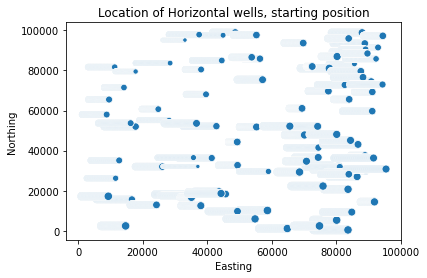

In [45]:
sns.scatterplot(data=big_df, x="easting", y="northing", size="lifetime_exp")
plt.ylabel("Northing")
plt.xlabel("Easting")
plt.title("Location of Horizontal wells, starting position")
plt.legend('', frameon=False) # remove the legend
plt.show()

In [ ]:
big_df.head()

In [ ]:
big_df.groupby(["Name"])

Change in water saturation